In [ ]:
import numpy as np
import random
import torch
import importlib
import os

import sys
sys.path.append('./..')

from models.network import AutoEncoder, ImageAutoEncoder
from data.data import ImNetImageSamples
from utils.debugger import MyDebugger
from torch.multiprocessing import Pool, Process, set_start_method


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


## folder for testing
testing_folder = r'./../pretrain/image_encoder'
config_path = os.path.join(testing_folder, 'config.py')

## import config here
spec = importlib.util.spec_from_file_location('*', config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

## dataload
### create dataset
data_path = r'./../data/all_vox256_img/all_vox256_img_train.hdf5'

testing_flag = True
if os.path.exists(config.data_path) and not testing_flag:
    data_path = config.data_path

model_type = f"AutoEncoder-{config.encoder_type}-{config.decoder_type}" if config.network_type == 'AutoEncoder' else f"AutoDecoder-{config.decoder_type}"

samples = ImNetImageSamples(data_path=data_path)

In [ ]:
samples.data_voxels.shape

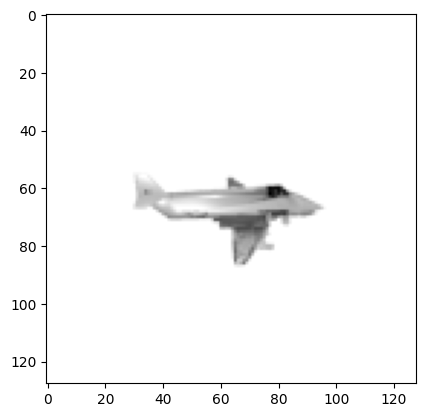

In [14]:
import matplotlib.pyplot as plt

plt.imshow(samples.data_pixels[0][2, 0], cmap='gray')

In [12]:
latent_vector_gt

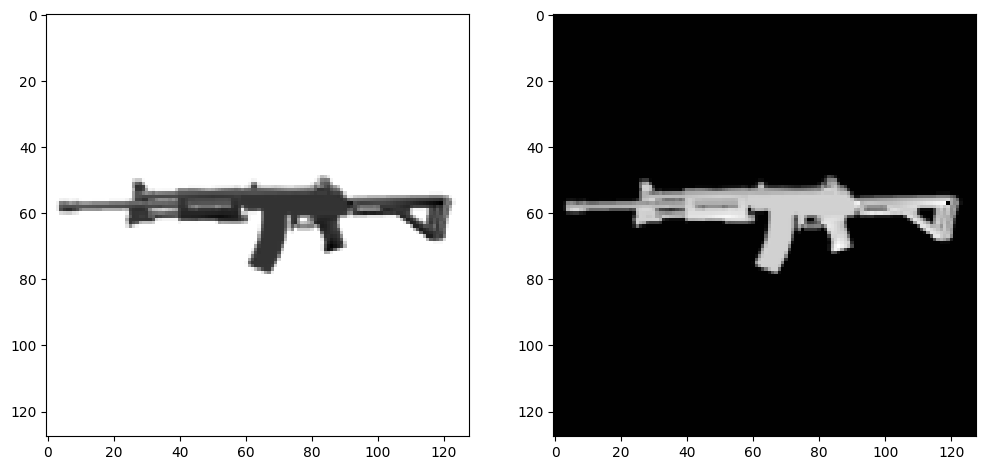

In [19]:
import matplotlib.pyplot as plt

img = samples.data_pixels[22440][2, 0].copy()

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(121)
ax.imshow(img, cmap='gray')

ax = fig.add_subplot(122)
ax.imshow(1 - img, cmap='gray')

In [1]:
import numpy as np
import random
import argparse
import importlib
import os

import sys
sys.path.append('../')

from data.data import ImNetImageSamples
from utils.ply_utils import read_ply_point_normal, read_ply_point


def calculate_cd(gt_points, pd_points):
    gt_num_points = gt_points.shape[0]
    pd_num_points = pd_points.shape[0]

    gt_points_tiled = np.tile(gt_points.reshape(gt_num_points, 1, 3), [1, pd_num_points, 1])
    pd_points_tiled = np.tile(pd_points.reshape(1, pd_num_points, 3), [gt_num_points, 1, 1])

    dist = ((gt_points_tiled - pd_points_tiled) ** 2).sum(axis=2)
    match_pd_gt = np.argmin(dist, axis=0)
    match_gt_pd = np.argmin(dist, axis=1)

    dist_pd_gt = ((pd_points - gt_points[match_pd_gt]) ** 2).mean() * 3
    dist_gt_pd = ((gt_points - pd_points[match_gt_pd]) ** 2).mean() * 3
    chamfer_distance = dist_pd_gt + dist_gt_pd

    return chamfer_distance


def calculate_normal_consistency(gt_points, pd_points, gt_normals, pd_normals):
    gt_num_points = gt_points.shape[0]
    pd_num_points = pd_points.shape[0]

    gt_points_tiled = np.tile(gt_points.reshape(gt_num_points, 1, 3), [1, pd_num_points, 1])
    pd_points_tiled = np.tile(pd_points.reshape(1, pd_num_points, 3), [gt_num_points, 1, 1])

    dist = ((gt_points_tiled - pd_points_tiled) ** 2).sum(axis=2)
    match_pd_gt = np.argmin(dist, axis=0)
    match_gt_pd = np.argmin(dist, axis=1)

    # Handle normals that point into wrong direction gracefully
    # (mostly due to mehtod not caring about this in generation)
    normals_dot_pd_gt = (np.abs((pd_normals * gt_normals[match_pd_gt]).sum(axis=1))).mean()
    normals_dot_gt_pd = (np.abs((gt_normals * pd_normals[match_gt_pd]).sum(axis=1))).mean()
    normal_consistency = (normals_dot_pd_gt + normals_dot_gt_pd) / 2

    return normal_consistency

In [2]:
samples = ImNetImageSamples(
    data_path='../data/all_vox256_img/all_vox256_img_test.hdf5', 
    label_txt_path='../data/all_vox256_img/all_vox256_img_test.txt'
)

In [3]:
# Setup parameters 
cd_res_per_class_dict = dict([
    (name, []) 
    for name in list(set(map(lambda x: x.split('/')[0], samples.obj_paths)))
])

normal_cons_res_per_class_dict = dict([
    (name, []) 
    for name in list(set(map(lambda x: x.split('/')[0], samples.obj_paths)))
])

eval_args = [
    (
        samples.data_points[i][np.squeeze(samples.data_values[i] > 1e-3)], 
        os.path.join('/res/folder/nt_test/pretrain_ply', samples.obj_paths[i], 'obj_deformed.ply'), 
        os.path.join('/res/folder/nt_test/pretrain_ply', samples.obj_paths[i], 'obj_orginal.ply'), 
        os.path.join('/res/folder/nt_test/pretrain_ply', samples.obj_paths[i], 'obj_normals.ply'), 
        os.path.join('/res/folder/datasets/shapenet/pointcloud_surface', f'{samples.obj_paths[i]}.ply') ,
        samples.obj_paths[i]
    ) 
    for i in range(len(samples))
]

In [4]:
vertices_gt, pd_ply, _, pd_normals_ply, gt_normal_ply, obj_path = eval_args[2176]

In [ ]:
# obj_path = '02691156/d199612c22fe9313f4fb6842b3610149'
pd_ply = os.path.join('/res/folder/nt_test/pretrain_ply', obj_path, 'obj_deformed.ply')
pd_normals_ply = os.path.join('/res/folder/nt_test/pretrain_ply', obj_path, 'obj_normals.ply')
gt_normal_ply = os.path.join('/res/folder/datasets/shapenet/pointcloud_surface', f'{obj_path}.ply')
pd_ply, pd_normals_ply, gt_normal_ply

In [6]:
vertices_normal_pd, normals_pd = read_ply_point_normal(pd_normals_ply)
vertices_normal_gt, normals_gt = read_ply_point_normal(gt_normal_ply)

normal_cons_calc = calculate_normal_consistency(
    vertices_normal_gt, vertices_normal_pd, 
    normals_gt, normals_pd
)

vertices_pd = read_ply_point(pd_ply)
cd_calc = calculate_cd(vertices_gt, vertices_pd)
cd_calc, normal_cons_calc

(0.00034808004056685604, 0.7416815757751465)

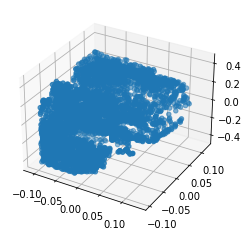

In [43]:
import matplotlib.pyplot as plt

ax = plt.figure().add_subplot(projection='3d')
_ = ax.scatter(vertices_normal_pd[:, 0], vertices_normal_pd[:, 1], vertices_normal_pd[:, 2], marker='o')

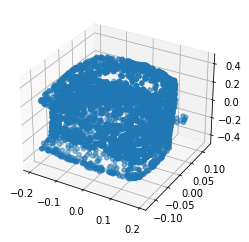

In [44]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.scatter(vertices_normal_gt[:, 0], vertices_normal_gt[:, 1], vertices_normal_gt[:, 2], marker='o')

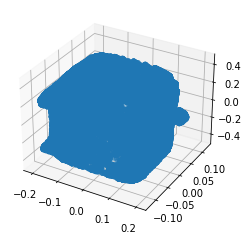

In [45]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.scatter(vertices_pd[:, 0], vertices_pd[:, 1], vertices_pd[:, 2], marker='o')